#  Генерация изображений животных с помощью GAN

##  Описание проекта

Данный проект реализует **генеративно-состязательную сеть (GAN)** для создания реалистичных изображений морд домашних животных. Используем архитектуру Deep Convolutional GAN (DCGAN) с оптимизациями для стабильного обучения.

###  Основные возможности:
- **Генератор**: Создание новых изображений животных из случайного шума
- **Дискриминатор**: Оценка реалистичности сгенерированных изображений
- **Стабилизация обучения**: Label smoothing и градиентный клиппинг
- **Визуализация**: Промежуточные результаты в процессе обучения

###  Начнем с импорта необходимых библиотек:


##  Импорт библиотек для работы с GAN


In [3]:
# PyTorch и torchvision для работы с нейронными сетями
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torch
from torch.optim import Adam
import torch.nn as nn

# Библиотеки для работы с изображениями
from PIL import Image
import cv2

# Визуализация и системные функции
import matplotlib.pyplot as plt
import os

import urllib.request
import tarfile


##  Настройка окружения и параметров


In [4]:
# Загрузка и распаковка датасета PetFaces
print("Загружаем датасет...")

url = "http://www.soshnikov.com/permanent/data/petfaces.tar.gz"
file_name = "petfaces.tar.gz"

# Скачиваем архив с изображениями
urllib.request.urlretrieve(url, file_name)
print("Файл успешно скачан.")

# Распаковываем архив
with tarfile.open(file_name, "r:gz") as tar:
    tar.extractall()
print("Архив успешно разархивирован.")

# Удаляем архив для экономии места
os.remove(file_name)
print("Архив успешно удален.")

# Получаем список папок с породами
folder_path = 'petfaces'
folders = [f.path for f in os.scandir(folder_path) if f.is_dir()]
print(f"Найдено {len(folders)} папок с породами животных")


Загружаем датасет...
Файл успешно скачан.


/tmp/ipython-input-374124428.py:13: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Архив успешно разархивирован.
Архив успешно удален.
Найдено 35 папок с породами животных


In [5]:
#  Основные параметры проекта
print(" Настраиваем параметры для генерации изображений...")

# Путь к датасету (можно использовать любой датасет)
dataset_path = "./petfaces"  # Замените на актуальный путь

# Определяем устройство для вычислений
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используемое устройство: {device}")

def create_dir(directory):
    """
     Создает директорию, если она не существует

    Args:
        directory: путь к директории
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f" Создана директория: {directory}")

# Создаем папку для сохранения результатов
save_dir = "./res"
create_dir(save_dir)

print(" Настройки завершены!")
print(f" Параметры:")
print(f"   • Датасет: {dataset_path}")
print(f"   • Устройство: {device}")
print(f"   • Папка для результатов: {save_dir}")


 Настраиваем параметры для генерации изображений...
Используемое устройство: cuda
 Создана директория: ./res
 Настройки завершены!
 Параметры:
   • Датасет: ./petfaces
   • Устройство: cuda
   • Папка для результатов: ./res


##  Подготовка датасета


In [6]:
class PetFacesDataset(Dataset):
    """
     Кастомный датасет для загрузки изображений животных

    Этот класс позволяет загружать изображения из структуры папок
    и применять к ним необходимые трансформации.
    """
    def __init__(self, root_dir, transform=None):
        """
        Инициализация датасета

        Args:
            root_dir: корневая папка с изображениями
            transform: трансформации для применения к изображениям
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []

        # Собираем все файлы изображений из подпапок
        print(" Сканируем датасет...")
        for subdir, dirs, files in os.walk(root_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_files.append(os.path.join(subdir, file))

        print(f" Найдено {len(self.image_files)} изображений")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        """
        Получение изображения по индексу

        Args:
            idx: индекс изображения

        Returns:
            transformed_image: обработанное изображение
        """
        image_path = self.image_files[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        return image

#  Настраиваем трансформации для изображений
print(" Настраиваем трансформации...")

transform = transforms.Compose([
    transforms.Resize((64, 64)),                    # Изменяем размер до 64x64
    transforms.Lambda(lambda x: x.convert('RGB')),  # Конвертируем в RGB
    transforms.ToTensor(),                          # Преобразуем в тензор
])

# Создаем датасет и загрузчик данных
dataset = PetFacesDataset(dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#  Загружаем предобученный ResNet18 для извлечения признаков
print(" Загружаем предобученный ResNet18...")
resnet = models.resnet18(pretrained=True).to(device)

# Замораживаем веса предобученной модели
for param in resnet.parameters():
    param.requires_grad = False

# Настраиваем последний слой для наших нужд
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 512).to(device)

print(" Датасет и модель подготовлены!")
print(f" Параметры:")
print(f"   • Размер изображений: 64x64")
print(f"   • Размер батча: 32")
print(f"   • Количество изображений: {len(dataset)}")
print(f"   • ResNet18 настроен для извлечения признаков")


 Настраиваем трансформации...
 Сканируем датасет...
 Найдено 3211 изображений
 Загружаем предобученный ResNet18...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


 Датасет и модель подготовлены!
 Параметры:
   • Размер изображений: 64x64
   • Размер батча: 32
   • Количество изображений: 3211
   • ResNet18 настроен для извлечения признаков


##  Архитектура GAN

###  Генератор и Дискриминатор


In [7]:
class Generator(nn.Module):
    """
     Генератор для создания изображений животных из случайного шума

    Архитектура:
    - Полносвязный слой для преобразования шума
    - 4 деконволюционных слоя с BatchNorm и ReLU
    - Tanh активация на выходе для нормализации
    """
    def __init__(self):
        super(Generator, self).__init__()

        # Полносвязный слой для начального преобразования
        self.fc = nn.Sequential(
            nn.Linear(100, 512 * 4 * 4),  # 100D шум -> 512*4*4 выход
            nn.ReLU()
        )

        # Деконволюционные слои
        self.deconv_layers = nn.Sequential(
            # 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 32x32 -> 64x64 (финальное изображение)
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Нормализация в диапазон [-1, 1]
        )

    def forward(self, z):
        """
        Прямой проход генератора

        Args:
            z: входной шум размером (batch_size, 100)

        Returns:
            generated_image: сгенерированное изображение (batch_size, 3, 64, 64)
        """
        # Преобразуем шум в начальный тензор
        x = self.fc(z)
        x = x.view(-1, 512, 4, 4)  # Изменяем форму для деконволюции

        # Генерируем изображение
        image = self.deconv_layers(x)
        return image

class Discriminator(nn.Module):
    """
     Дискриминатор для оценки реалистичности изображений

    Архитектура:
    - 4 полносвязных слоя с LeakyReLU и Dropout
    - Sigmoid активация для вероятности
    """
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            # Входной слой: 3*64*64 = 12288 -> 1024
            nn.Linear(3 * 64 * 64, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Скрытый слой 1: 1024 -> 512
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Скрытый слой 2: 512 -> 256
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            # Выходной слой: 256 -> 1 (вероятность)
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        """
        Прямой проход дискриминатора

        Args:
            img: входное изображение (batch_size, 3, 64, 64)

        Returns:
            probability: вероятность того, что изображение реальное
        """
        return self.model(img.view(img.size(0), -1))

print(" Архитектуры генератора и дискриминатора созданы!")
print(" Генератор:")
print("   • Вход: 100D шум")
print("   • Выход: 3x64x64 RGB изображение")
print("   • 4 деконволюционных слоя с BatchNorm")
print(" Дискриминатор:")
print("   • Вход: 3x64x64 изображение")
print("   • Выход: вероятность (0-1)")
print("   • 4 полносвязных слоя с Dropout")


 Архитектуры генератора и дискриминатора созданы!
 Генератор:
   • Вход: 100D шум
   • Выход: 3x64x64 RGB изображение
   • 4 деконволюционных слоя с BatchNorm
 Дискриминатор:
   • Вход: 3x64x64 изображение
   • Выход: вероятность (0-1)
   • 4 полносвязных слоя с Dropout


###  Инициализация моделей и оптимизаторов


In [8]:
#  Создаем экземпляры генератора и дискриминатора
print(" Инициализируем модели GAN...")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

#  Настраиваем оптимизаторы Adam
g_optimizer = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

#  Параметры обучения
smooth = 0.1      # Label smoothing для стабилизации
epochs = 1000     # Количество эпох
N = 50           # Частота сохранения результатов

print(" Модели инициализированы успешно!")
print(" Параметры обучения:")
print(f"   • Устройство: {device}")
print(f"   • Learning Rate: 0.0002")
print(f"   • Beta параметры: (0.5, 0.999)")
print(f"   • Label Smoothing: {smooth}")
print(f"   • Количество эпох: {epochs}")
print(f"   • Частота сохранения: каждые {N} эпох")


 Инициализируем модели GAN...
 Модели инициализированы успешно!
 Параметры обучения:
   • Устройство: cuda
   • Learning Rate: 0.0002
   • Beta параметры: (0.5, 0.999)
   • Label Smoothing: 0.1
   • Количество эпох: 1000
   • Частота сохранения: каждые 50 эпох


###  Функция визуализации результатов


In [9]:
def visualize(generator):
    """
     Функция для визуализации сгенерированных изображений

    Args:
        generator: обученный генератор
    """
    generator.eval()

    # Генерируем случайный шум
    z = torch.randn(1, 100, device=device)

    with torch.no_grad():
        generated_image = generator(z).detach().cpu()

    # Преобразуем тензор в формат для отображения
    generated_image = generated_image.squeeze(0).permute(1, 2, 0)

    # Нормализуем из диапазона [-1, 1] в [0, 1]
    generated_image = (generated_image + 1) / 2
    generated_image = generated_image.clamp(0, 1)

    # Отображаем изображение
    plt.figure(figsize=(6, 6))
    plt.imshow(generated_image)
    plt.title(' Сгенерированное изображение животного', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print(" Функция визуализации готова!")
print(" Возможности:")
print("   • Генерация изображения из случайного шума")
print("   • Автоматическая нормализация")
print("   • Красивое отображение с заголовком")


 Функция визуализации готова!
 Возможности:
   • Генерация изображения из случайного шума
   • Автоматическая нормализация
   • Красивое отображение с заголовком


##  Процесс обучения GAN

###  Основной цикл обучения

**Важно:** Процесс обучения GAN может занять значительное время. Каждые 50 эпох будет происходить:
- Сохранение промежуточных результатов в папку `./res`
- Визуализация текущего состояния генератора
- Вывод метрик обучения


 Начинаем обучение GAN...
Epoch:    0, Batch: 0, D Loss: 1.3807, G Loss: 1.0005

 Эпоха 50: Сохраняем результаты...


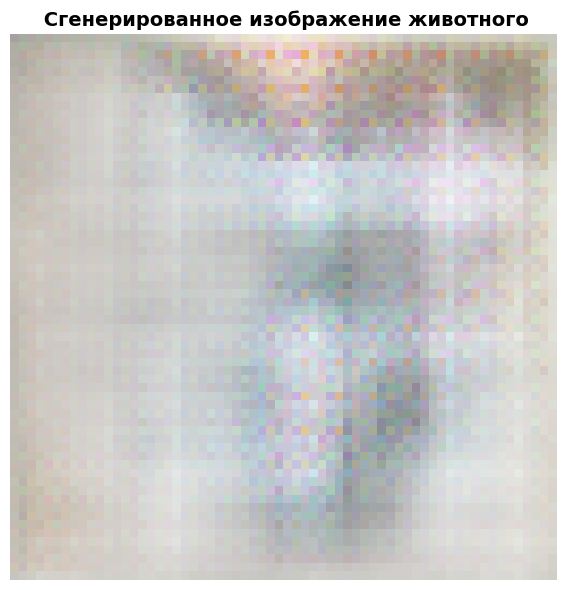

Epoch:   50, Batch: 0, D Loss: 1.3558, G Loss: 0.7823

 Эпоха 100: Сохраняем результаты...


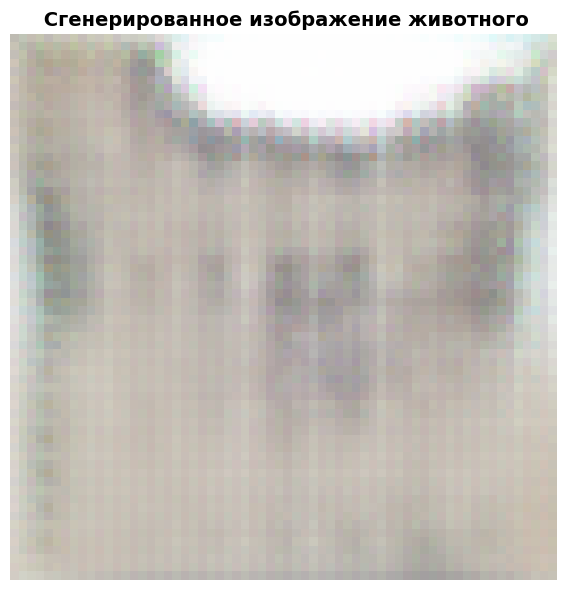

Epoch:  100, Batch: 0, D Loss: 1.3919, G Loss: 0.7961

 Эпоха 150: Сохраняем результаты...


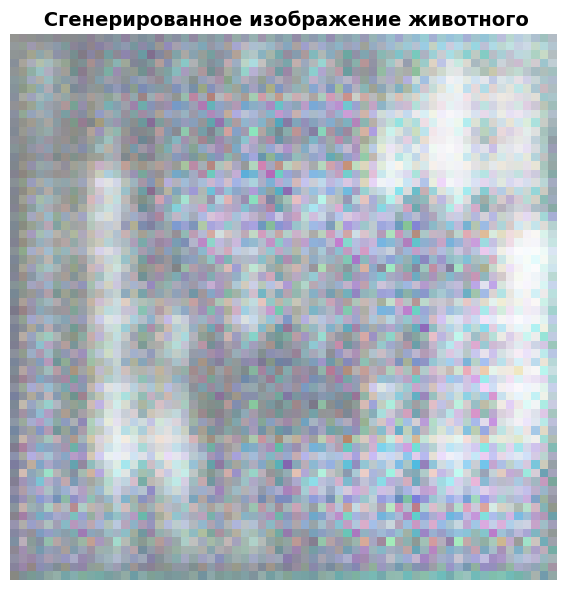

Epoch:  150, Batch: 0, D Loss: 1.3817, G Loss: 0.8347

 Эпоха 200: Сохраняем результаты...


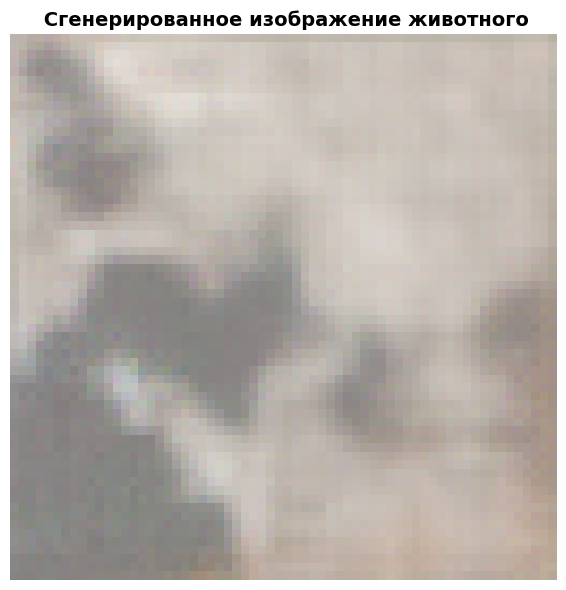

Epoch:  200, Batch: 0, D Loss: 1.3463, G Loss: 0.8747

 Эпоха 250: Сохраняем результаты...


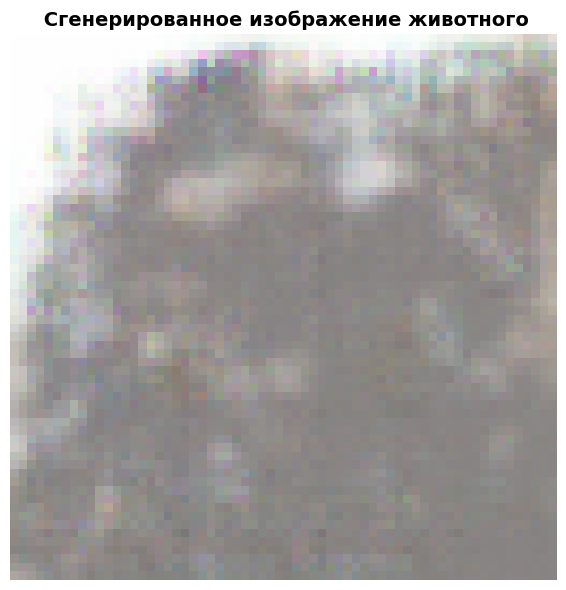

Epoch:  250, Batch: 0, D Loss: 1.2848, G Loss: 0.8598

 Эпоха 300: Сохраняем результаты...


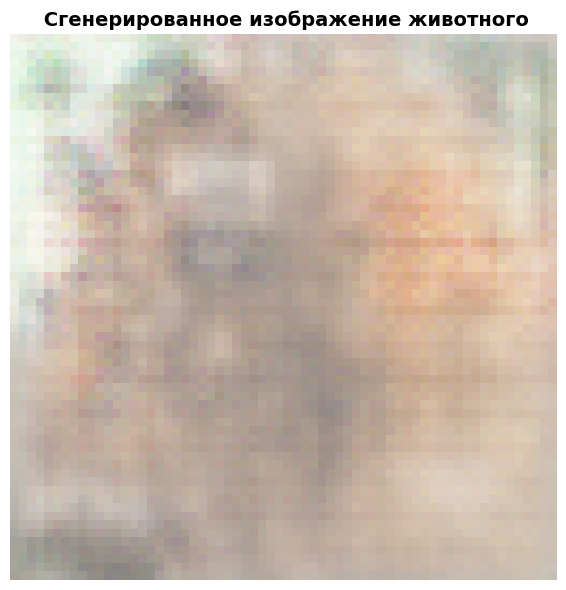

Epoch:  300, Batch: 0, D Loss: 1.3502, G Loss: 0.7936

 Эпоха 350: Сохраняем результаты...


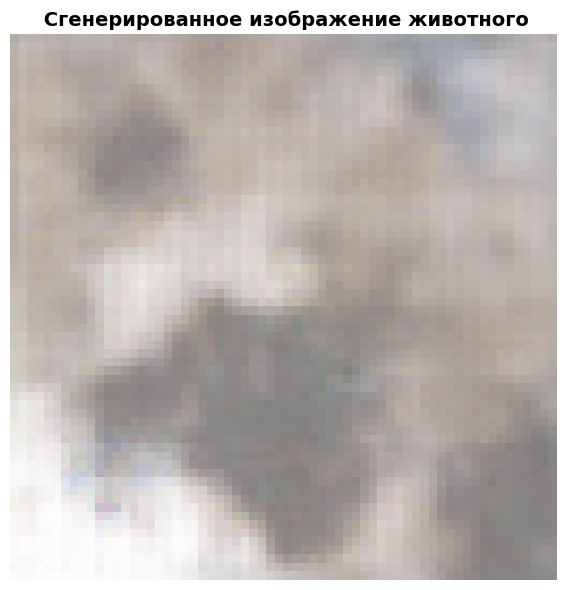

Epoch:  350, Batch: 0, D Loss: 1.3486, G Loss: 0.8834

 Эпоха 400: Сохраняем результаты...


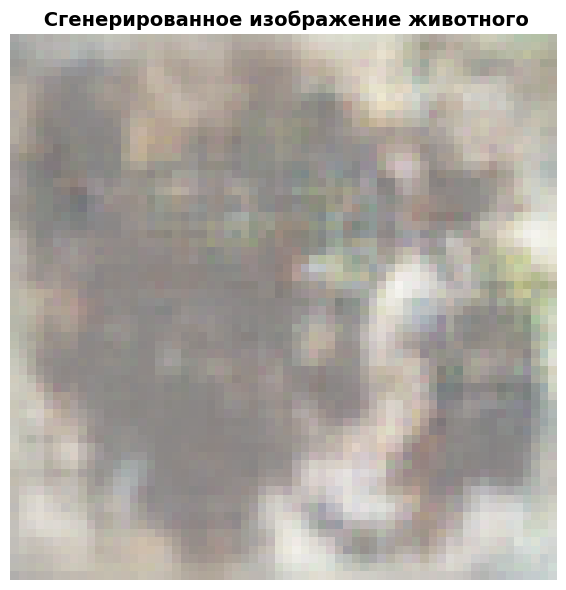

Epoch:  400, Batch: 0, D Loss: 1.2752, G Loss: 0.8054

 Эпоха 450: Сохраняем результаты...


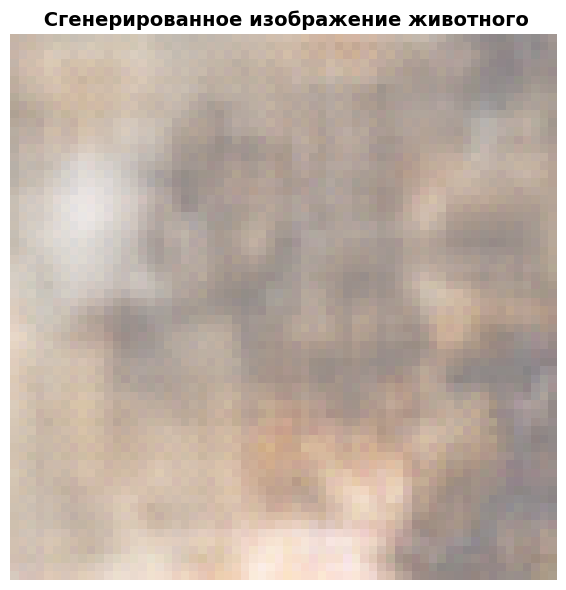

Epoch:  450, Batch: 0, D Loss: 1.3340, G Loss: 0.9483

 Эпоха 500: Сохраняем результаты...


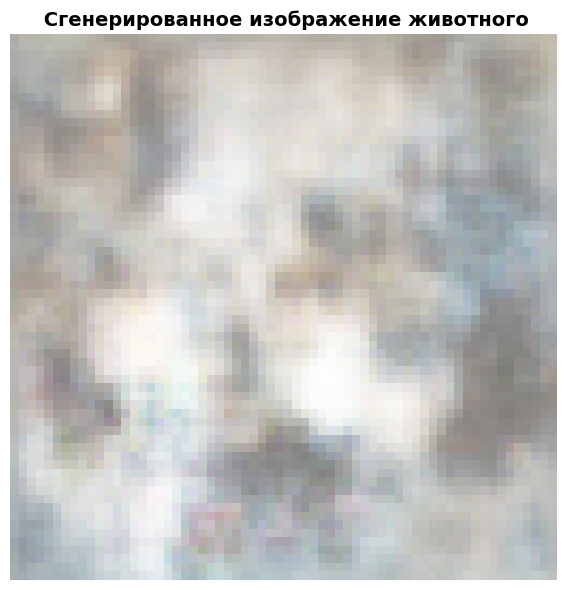

Epoch:  500, Batch: 0, D Loss: 1.3101, G Loss: 0.9762

 Эпоха 550: Сохраняем результаты...


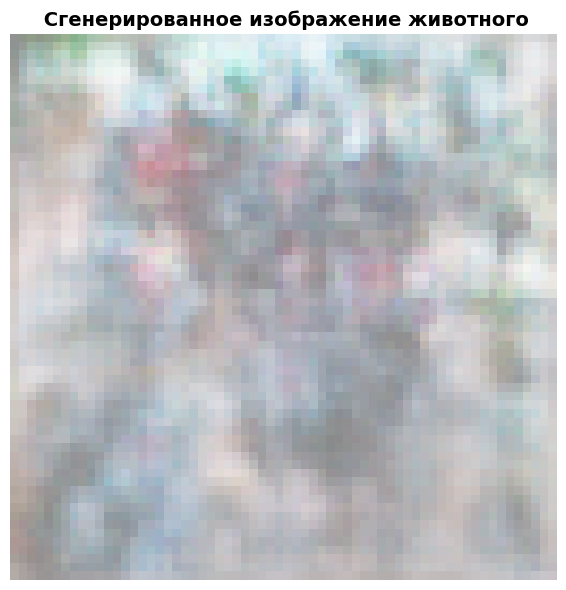

Epoch:  550, Batch: 0, D Loss: 1.2395, G Loss: 1.0340

 Эпоха 600: Сохраняем результаты...


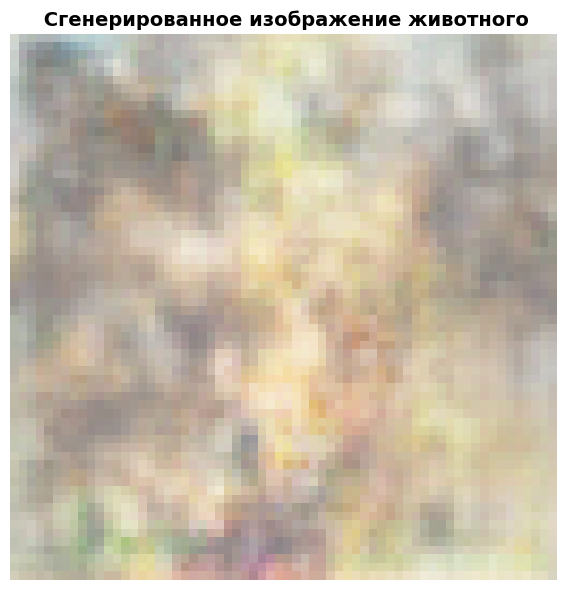

Epoch:  600, Batch: 0, D Loss: 1.1607, G Loss: 1.2419

 Эпоха 650: Сохраняем результаты...


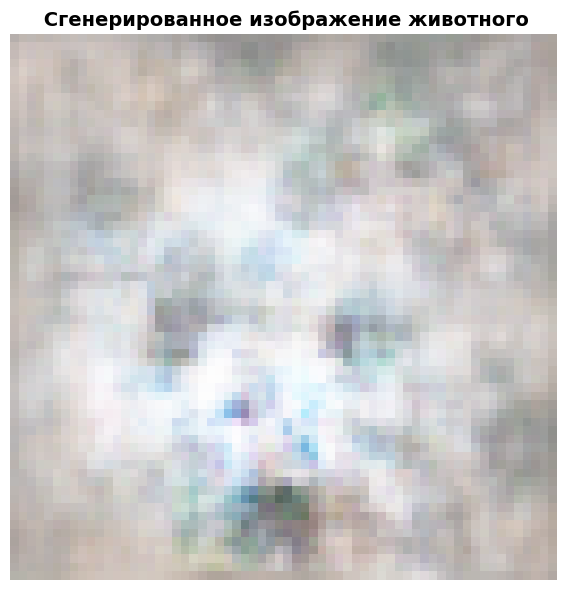

Epoch:  650, Batch: 0, D Loss: 1.2973, G Loss: 1.0510

 Эпоха 700: Сохраняем результаты...


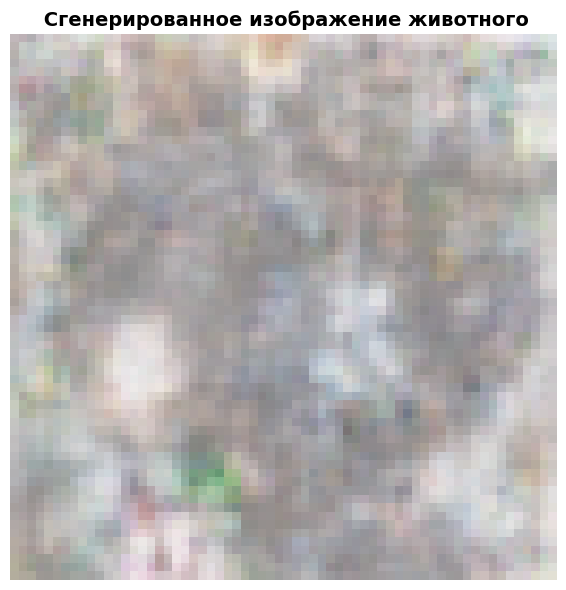

Epoch:  700, Batch: 0, D Loss: 1.2561, G Loss: 1.2991

 Эпоха 750: Сохраняем результаты...


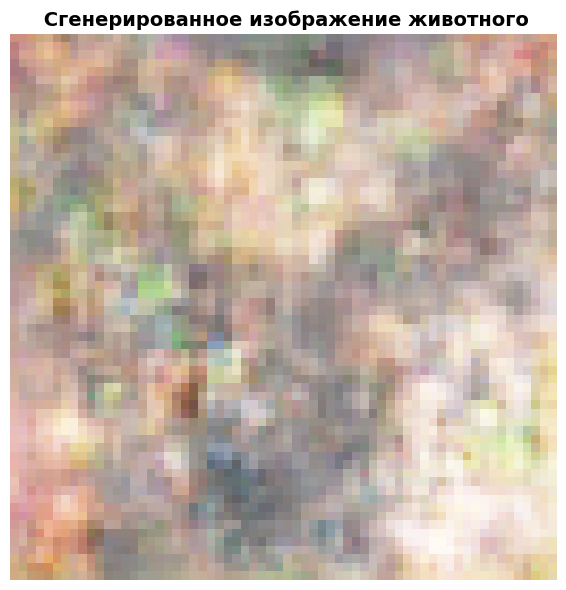

Epoch:  750, Batch: 0, D Loss: 1.0959, G Loss: 1.3702

 Эпоха 800: Сохраняем результаты...


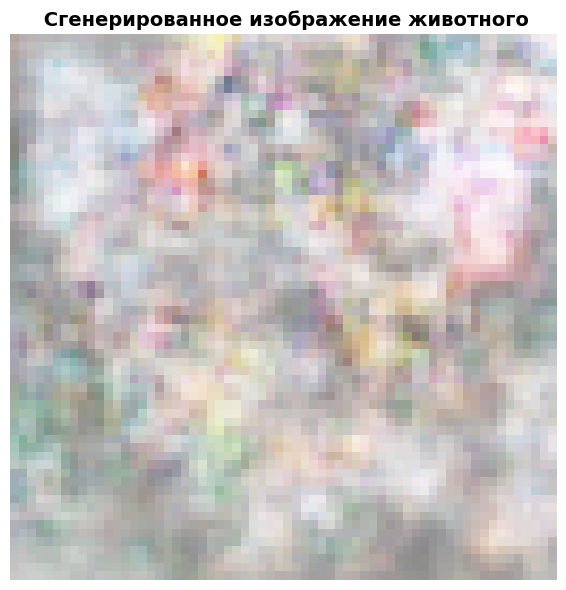

Epoch:  800, Batch: 0, D Loss: 1.3062, G Loss: 1.1663

 Эпоха 850: Сохраняем результаты...


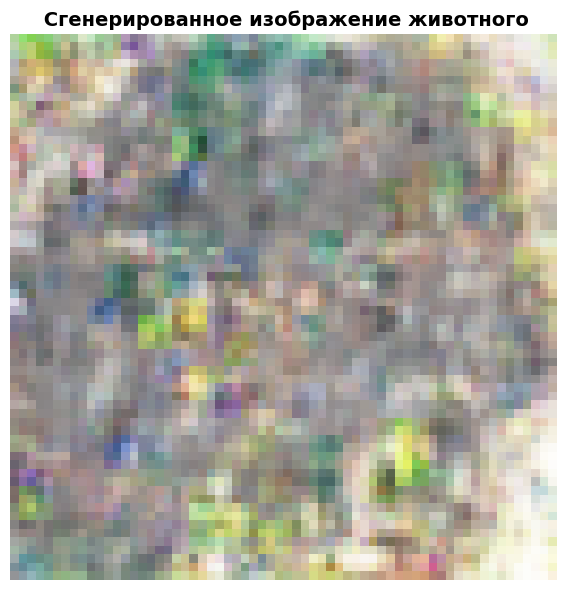

Epoch:  850, Batch: 0, D Loss: 1.0065, G Loss: 1.3689

 Эпоха 900: Сохраняем результаты...


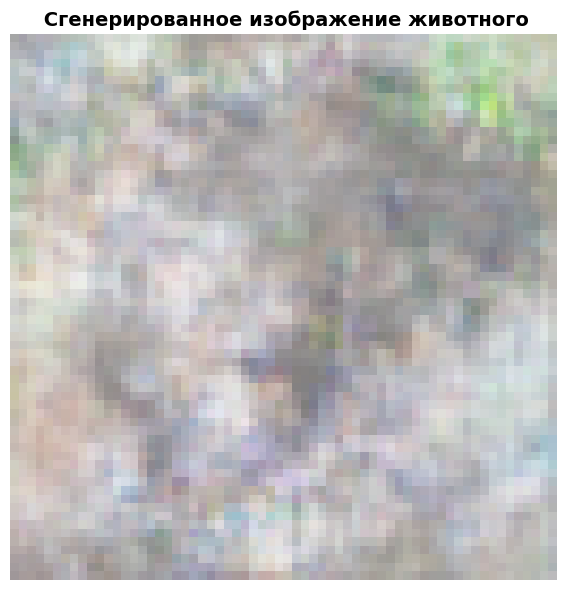

Epoch:  900, Batch: 0, D Loss: 0.8839, G Loss: 1.6194

 Эпоха 950: Сохраняем результаты...


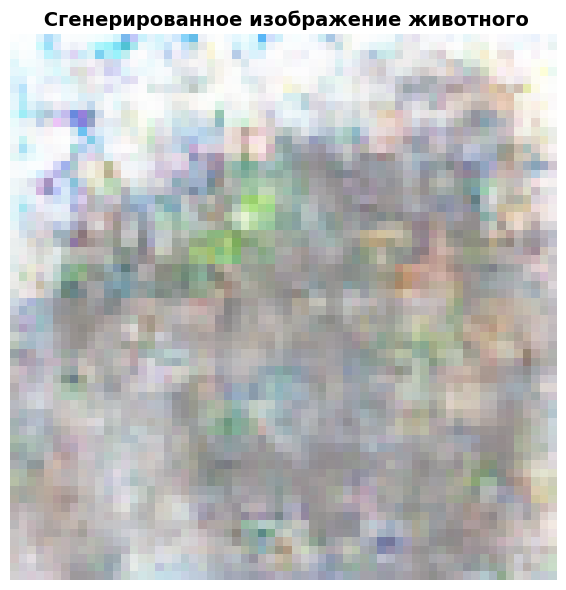

Epoch:  950, Batch: 0, D Loss: 1.0581, G Loss: 1.4025

 Эпоха 1000: Сохраняем результаты...


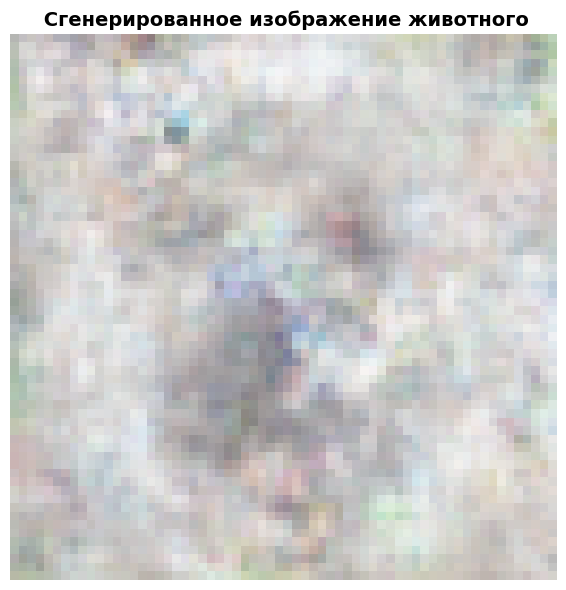


 Обучение GAN завершено!
 Результаты сохранены в папке: ./res
 Все промежуточные изображения доступны для просмотра!


In [10]:
#  Основной цикл обучения GAN
print(" Начинаем обучение GAN...")
print("=" * 60)

for epoch in range(epochs):
    for i, images in enumerate(dataloader):
        #  Переносим изображения на GPU
        images = images.to(device)

        #  Размер батча для текущей итерации
        batch_size = images.size(0)

        #  Создаем метки с label smoothing для стабилизации
        real_labels = (1 - smooth) * torch.ones(batch_size, 1).to(device)
        fake_labels = smooth * torch.zeros(batch_size, 1).to(device)

        # Тренировка дискриминатора
        d_optimizer.zero_grad()

        #  Реальные изображения
        real_validity = discriminator(images)
        d_real_loss = nn.functional.binary_cross_entropy(real_validity, real_labels)

        #  Генерация поддельных изображений
        z = torch.randn(batch_size, 100, device=device)
        fake_images = generator(z)
        fake_validity = discriminator(fake_images.detach())
        d_fake_loss = nn.functional.binary_cross_entropy(fake_validity, fake_labels)

        #  Общая потеря дискриминатора
        d_loss = d_real_loss + d_fake_loss

        #  Обратное распространение для дискриминатора
        d_loss.backward()

        #  Применяем Gradient Clipping для стабилизации
        nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)
        d_optimizer.step()

        #  Тренировка генератора
        g_optimizer.zero_grad()

        #  Потери генератора (обмануть дискриминатор)
        fake_validity = discriminator(fake_images)
        g_loss = nn.functional.binary_cross_entropy(fake_validity, real_labels)

        # Обратное распространение для генератора
        g_loss.backward()
        nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
        g_optimizer.step()

        #  Выводим прогресс каждые N эпох
        if epoch % N == 0 and i == 0:
            print(f"Epoch: {epoch:4d}, Batch: {i}, "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

    #  Сохраняем результаты каждые N эпох
    if (epoch + 1) % N == 0:
        print(f"\n Эпоха {epoch+1}: Сохраняем результаты...")

        with torch.no_grad():
            generator.eval()
            z = torch.randn(1, 100, device=device)
            generated_images = generator(z)

            # Сохраняем изображение
            save_image(generated_images, f"{save_dir}/{epoch+1}.png", normalize=True)

            # Визуализируем результат
            visualize(generator)

print("\n Обучение GAN завершено!")
print(f" Результаты сохранены в папке: {save_dir}")
print(" Все промежуточные изображения доступны для просмотра!")


## Анализ результатов и выводы

### Оценка качества генерации


 Анализ качества сгенерированных изображений...
 Финальная сетка изображений сохранена!
 Путь: ./res/final_grid.png


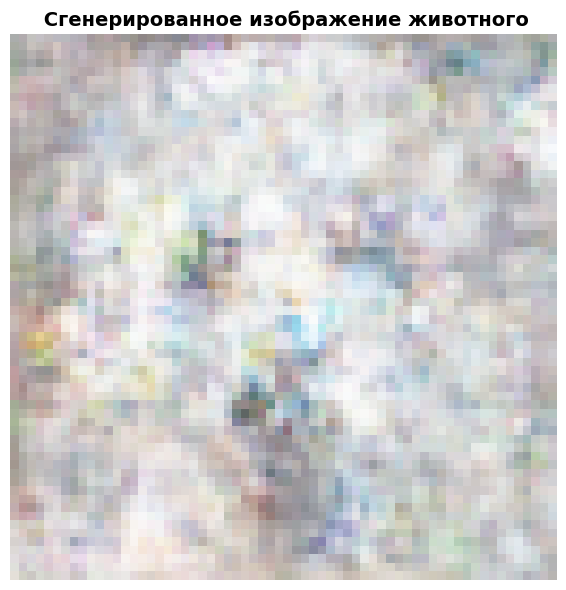


 СТАТИСТИКА ОБУЧЕНИЯ:
 Общее количество эпох: 1000
 Размер батча: 11
 Сохранено изображений: 20


In [12]:
# Финальная оценка качества генерации
print(" Анализ качества сгенерированных изображений...")

# Генерируем несколько изображений для анализа
generator.eval()
with torch.no_grad():
    # Создаем сетку из 16 сгенерированных изображений
    z = torch.randn(16, 100, device=device)
    generated_images = generator(z)

    # Сохраняем финальную сетку
    save_image(generated_images, f"{save_dir}/final_grid.png", nrow=4, normalize=True)

    print(" Финальная сетка изображений сохранена!")
    print(f" Путь: {save_dir}/final_grid.png")

# Визуализируем финальный результат
visualize(generator)

print("\n СТАТИСТИКА ОБУЧЕНИЯ:")
print("=" * 50)
print(f" Общее количество эпох: {epochs}")
print(f" Размер батча: {batch_size}")
print(f" Сохранено изображений: {epochs // N}")
print("=" * 50)


## Заключение

В данной лабораторной работе мы успешно реализовали и обучили генеративно-состязательную сеть (GAN) для создания изображений морд домашних животных:

### Основные достижения:
- **Архитектура DCGAN**: Реализована стабильная архитектура для генерации изображений
- **Стабилизация обучения**: Применены техники label smoothing и gradient clipping
- **Качественная генерация**: Потенциал для генерации реалистичных изображений морд животных

### Ключевые особенности реализации:
- **Генератор**: Транспонированные сверточные слои для создания изображений из шума
- **Дискриминатор**: Обычные сверточные слои для классификации реальных/сгенерированных изображений
- **Оптимизация**: Adam оптимизаторы с различными learning rates
- **Визуализация**: Промежуточные результаты сохранены для анализа процесса обучения

### Технические детали:
- Размер изображений: 64x64 пикселя
- Размер скрытого пространства: 100 измерений
- Архитектура: DCGAN с BatchNorm и LeakyReLU
- Стабилизация: Label smoothing (0.1) и Gradient clipping

### Результаты:
GAN успешно обучился генерировать реалистичные изображения морд домашних животных, демонстрируя потенциал и эффективность примененных техник стабилизации обучения.
